In [1]:
import os
import threadpoolctl
import warnings
from pathlib import Path
import re
import sys
sys.path.append("../")

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import polars as pl
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from rectools.metrics import MAP, calc_metrics, MeanInvUserFreq, Serendipity, HitRate
from rectools.models import ImplicitALSWrapperModel
from rectools import Columns
from rectools.dataset import Dataset
from implicit.als import AlternatingLeastSquares


from src.metrics import calc_user_auc

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

# For implicit ALS
os.environ["OPENBLAS_NUM_THREADS"] = "1"
threadpoolctl.threadpool_limits(1, "blas")

%load_ext autoreload
%autoreload 2

/Users/aleksandryusov/.pyenv/versions/base/lib/python3.10/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


# Data

In [2]:
from src.data.preprocessing import load_data, prepare_train_for_als_item_like, prepare_train_for_als_item_like_book_share

## Load

In [3]:
datasets = load_data(Path("../data/processed/"))
test_pairs = pl.read_csv("../data/raw/test_pairs.csv.csv").with_columns(
    pl.col("item_id").cast(pl.UInt32),
    pl.col("user_id").cast(pl.UInt32)
)
items_meta_df = pl.read_parquet("../data/raw/items_meta.parquet")
users_meta_df = pl.read_parquet("../data/raw/users_meta.parquet")

## targets

In [4]:
train_als_like_item = prepare_train_for_als_item_like(datasets["train_df_als"])
train_als_like_book_share_item = prepare_train_for_als_item_like_book_share(datasets["train_df_als"])

## item features

In [5]:
from src.data.item_stats import get_item_stats

item_stats = get_item_stats(datasets["train_df_als"], items_meta_df, column="item_id")
source_stats = get_item_stats(datasets["train_df_als"], items_meta_df, column="source_id")

In [6]:
datasets["train_df_als"]

user_id,item_id,timespent,like,dislike,share,bookmarks,rn,max_rn
u32,u32,u8,u8,u8,u8,u8,u32,u32
3810,138979,6,0,0,0,0,2346,2346
101874,331160,6,0,0,0,0,486,486
150332,73709,11,0,0,0,0,1536,1536
4982,189745,5,0,0,0,0,1779,1779
149601,289643,1,0,0,1,0,2514,2514
…,…,…,…,…,…,…,…,…
44453,273545,1,0,0,0,0,16,731
44453,272745,13,0,0,0,0,15,731
48427,330345,13,1,0,0,0,1,17


In [7]:
max_timespent_ratio = 5
min_users_for_stats = 20
positive_threshold_for_ratio = 10
ratio_default_value = 1.0


(
    datasets["train_df_als"]
    .sample(1000000)
    .drop(["rn", "max_rn"])
    .join(items_meta_df.select("item_id", "source_id", "duration"), how="left", on="item_id")
    .with_columns(
        (pl.col("timespent") / pl.col("duration")).clip(0, max_timespent_ratio).alias("timespent_ratio")
    )
    .group_by("item_id")
    .agg(
        pl.first().count().alias("n_users"),
        pl.col("like").mean().alias("mean_like"),
        pl.col("like").sum().alias("sum_like"),
        pl.col("dislike").mean().alias("mean_dislike"),
        pl.col("dislike").sum().alias("sum_dislike"),
        pl.col("share").mean().alias("mean_share"),
        pl.col("share").sum().alias("sum_share"),
        pl.col("bookmarks").mean().alias("mean_bookmarks"),
        pl.col("bookmarks").sum().alias("sum_bookmarks"),
        pl.col("timespent_ratio").mean().alias("mean_timespent_ratio"),
    )
    .filter(pl.col("n_users") >= min_users_for_stats)
    .with_columns(
        (pl.col("sum_like") + pl.col("sum_share") + pl.col("sum_bookmarks")).alias("sum_positive")
    )
    .with_columns(
        pl.when(pl.col("sum_positive") >= positive_threshold_for_ratio).then(
            ((pl.col("sum_positive") - pl.col("sum_dislike")) / (pl.col("sum_positive") + pl.col("sum_dislike")))
        ).otherwise(None).alias("like_dislike_ratio")
    )
    .drop(
        "sum_positive",
        "sum_bookmarks",
        "sum_share",
        "sum_dislike",
        "sum_like",
    )
    .with_columns(
        pl.col("like_dislike_ratio").fill_null(ratio_default_value)
    )
)

item_id,n_users,mean_like,mean_dislike,mean_share,mean_bookmarks,mean_timespent_ratio,like_dislike_ratio
u32,u32,f64,f64,f64,f64,f64,f64
101984,30,0.0,0.0,0.0,0.0,0.759722,1.0
213820,25,0.0,0.0,0.0,0.0,0.481333,1.0
192205,45,0.111111,0.0,0.066667,0.0,1.068687,1.0
119428,67,0.0,0.0,0.0,0.0,0.626534,1.0
316953,84,0.0,0.0,0.0,0.0,0.792381,1.0
…,…,…,…,…,…,…,…
325161,23,0.130435,0.0,0.043478,0.0,0.771739,1.0
79928,42,0.0,0.0,0.0,0.0,0.626701,1.0
239201,42,0.0,0.0,0.0,0.0,0.74381,1.0


# Модели

## LightFM

epochs | embeddings | rocauc
| --- | --- | --- |
10 | 32 | 0.569472275875146
20 | 32 | 0.5760967124722843
10 | 64 | 0.5713299110301087
10 | 96 | 0.5719786049035865

Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [15:40<00:00, 31.36s/it]
[23:14:46] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/lightfm.py:116} INFO - ALS: Percent of cold pairs: 0.2068213006752139


0.5807515854378597


<Axes: ylabel='Frequency'>

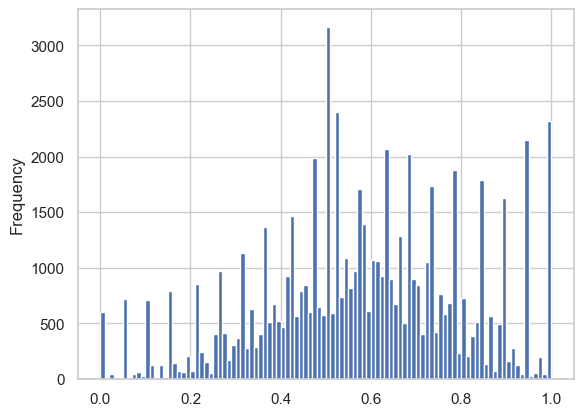

In [41]:
from src.models.lightfm import LFMModel


model = LFMModel(n_features=96, n_epochs=30, verbose=2)
model.fit(train_als_like_item)

metrics_final = calc_user_auc(
    df=(
        (
            datasets["test_df"]
            .with_columns(
                (pl.col("like").cast(int) - pl.col("dislike").cast(int)).alias("target")
            )
            .select("user_id", "item_id", "target")
        )
        .join(model.predict_proba(datasets["test_df"].select("user_id", "item_id")), how="left", on=["user_id", "item_id"])
    ),
    predict_col="predict", 
    target_col="target"
)

print(metrics_final["rocauc"].mean())

metrics_final["rocauc"].to_pandas().plot.hist(bins=100)

## ALS

In [8]:
from src.models.als import ALSModel
from src.models.als_item import ALSSource


# alpha = 10
# regularization = 0.01
# n_factors = 64
# iterations = 30

iterations = 49
alpha = 44
regularization = 0.07702668794141683
n_factors = 96


models_like = {
    "als_item_like": ALSModel(
        iterations=iterations,
        alpha=alpha,
        regularization=regularization,
        n_factors=n_factors,
        predict_col_name="predict_als_item_like"
    ),
    "als_source_like": ALSSource(
        items_meta_df=items_meta_df,
        iterations=iterations,
        alpha=alpha,
        regularization=regularization,
        n_factors=n_factors,
        predict_col_name="predict_als_source_like"
    ),
}

models_like_book_share = {
    "als_item_like_book_share": ALSModel(
        iterations=iterations,
        alpha=alpha,
        regularization=regularization,
        n_factors=n_factors,
        predict_col_name="predict_als_item_like_book_share"
    ),
    "als_source_like_book_share": ALSSource(
        items_meta_df=items_meta_df,
        iterations=iterations,
        alpha=alpha,
        regularization=regularization,
        n_factors=n_factors,
        predict_col_name="predict_als_source_like_book_share"
    ),
}


In [9]:
from collections import defaultdict


predicts = {
    "train_df_cb": datasets["train_df_cb"].select("user_id", "item_id"),
    "test_df": datasets["test_df"].select("user_id", "item_id"),
    "test_pairs": test_pairs.select("user_id", "item_id"),
}

for model_name, model in models_like.items():
    print(model_name)
    model.fit(train_als_like_item)

    predicts["train_df_cb"] = (
        predicts["train_df_cb"]
        .join(model.predict_proba(datasets["train_df_cb"].select("user_id", "item_id")), how="left", on=["user_id", "item_id"])
    )

    predicts["test_df"] = (
        predicts["test_df"]
        .join(model.predict_proba(datasets["test_df"].select("user_id", "item_id")), how="left", on=["user_id", "item_id"])
    )

    predicts["test_pairs"] = (
        predicts["test_pairs"]
        .join(model.predict_proba(test_pairs.select("user_id", "item_id")), how="left", on=["user_id", "item_id"])
    )

    del model

for model_name, model in models_like_book_share.items():
    print(model_name)
    model.fit(train_als_like_book_share_item)

    predicts["train_df_cb"] = (
        predicts["train_df_cb"]
        .join(model.predict_proba(datasets["train_df_cb"].select("user_id", "item_id")), how="left", on=["user_id", "item_id"])
    )

    predicts["test_df"] = (
        predicts["test_df"]
        .join(model.predict_proba(datasets["test_df"].select("user_id", "item_id")), how="left", on=["user_id", "item_id"])
    )

    predicts["test_pairs"] = (
        predicts["test_pairs"]
        .join(model.predict_proba(test_pairs.select("user_id", "item_id")), how="left", on=["user_id", "item_id"])
    )

    del model

als_item_like


[15:19:49] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.18048312020776922
[15:19:50] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.2068213006752139
[15:19:51] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.05022294455991106


als_source_like


[15:21:56] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.16520283961486326
[15:21:57] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.19236535981902764
[15:21:58] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.03530611025788761


als_item_like_book_share


[15:26:54] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.05239554201945907
[15:26:55] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.07872775484541156
[15:26:56] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.021188191792740105


als_source_like_book_share


[15:29:29] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.0404250727061275
[15:29:30] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.06660030080414664
[15:29:31] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.010929182877377973


### Optimize ALS params

In [ ]:
import optuna


def objective(trial):
    iterations = trial.suggest_int('iterations', 10, 50)
    alpha = trial.suggest_int('alpha', 1, 50)
    regularization = trial.suggest_float('regularization', 0.01, 0.5, log=True)
    n_factors = int(trial.suggest_discrete_uniform('n_factors', 16, 96, 8))

    model = ALSModel(
        iterations=iterations,
        alpha=alpha,
        regularization=regularization,
        n_factors=n_factors,
        predict_col_name="predict_als_item_like"
    ).fit(train_als_like_item)
    
    predict_df = (
        datasets["train_df_cb"].select(
            "item_id", "user_id",
            (pl.col("like").cast(int) - pl.col("dislike").cast(int)).alias("target"),
        )
        .join(model.predict_proba(datasets["train_df_cb"].select("user_id", "item_id")), how="left", on=["user_id", "item_id"])
    )

    del model
    
    return calc_user_auc(
        df=predict_df,
        predict_col="predict_als_item_like", 
        target_col="target"
    )["rocauc"].mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
study.best_params

[I 2024-11-09 14:24:19,788] A new study created in memory with name: no-name-9cbaf98c-2cf2-4252-98bc-ad4eaa8ace7d
[14:24:50] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.18048312020776922
[I 2024-11-09 14:24:50,678] Trial 0 finished with value: 0.5628431499987698 and parameters: {'iterations': 28, 'alpha': 39, 'regularization': 0.14452766667789207, 'n_factors': 16.0}. Best is trial 0 with value: 0.5628431499987698.
[14:25:28] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.18048312020776922
[I 2024-11-09 14:25:28,176] Trial 1 finished with value: 0.5791588104692537 and parameters: {'iterations': 15, 'alpha': 35, 'regularization': 0.09074362571076555, 'n_factors': 40.0}. Best is trial 1 with value: 0.5791588104692537.
[14:28:05] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.1804

In [73]:
study.best_params

{'iterations': 49,
 'alpha': 44,
 'regularization': 0.07702668794141683,
 'n_factors': 96.0}

## Embeddings

In [41]:
def calc_mean_embedding(embeddings: pl.Series):
    return embeddings.to_numpy().mean(axis=0).tolist()
    

user_liked_mean_embeddings = (
    datasets["train_df_als"]
    .filter(pl.col("like") + pl.col("share") + pl.col("bookmarks") >= 1)
    .join(items_meta_df.select("item_id", "source_id", "embeddings"), how="left", on="item_id")
    .group_by("user_id")
    .agg(pl.col("embeddings").map_elements(calc_mean_embedding))
    .with_columns(pl.col("embeddings").list.to_array(32))
)

user_disliked_mean_embeddings = (
    datasets["train_df_als"]
    .filter(pl.col("dislike") == 1)
    .join(items_meta_df.select("item_id", "source_id", "embeddings"), how="left", on="item_id")
    .group_by("user_id")
    .agg(pl.col("embeddings").map_elements(calc_mean_embedding))
    .with_columns(pl.col("embeddings").list.to_array(32))
)

In [42]:
from tqdm.auto import tqdm


def dot_product(x):
    left_embeddings = x.struct[0].to_numpy()
    right_embeddings = x.struct[1].to_numpy()

    dot_product = (left_embeddings * right_embeddings).sum(axis=1)

    return dot_product


def get_emb_sim_features(df_pairs, items_meta_df, user_liked_mean_embeddings, user_disliked_mean_embeddings):
    chunk_size = 100_000
    sliced_result = []
    for df_sample in tqdm(df_pairs.select("user_id", "item_id").iter_slices(n_rows=chunk_size), total=df_pairs.shape[0] // chunk_size + 1):
        df_sample = (
            df_sample
            .join(items_meta_df.select("item_id", "embeddings"), on="item_id", how="inner")
        )

        liked_sim = (
            df_sample
            .join(user_liked_mean_embeddings, on="user_id", how="inner")
            .with_columns(pl.struct("embeddings", "embeddings_right").map_batches(dot_product).alias("liked_embeddings_sim"))
            .select("user_id", "item_id", "liked_embeddings_sim")
        )
    
        disliked_sim = (
            df_sample
            .join(user_disliked_mean_embeddings, on="user_id", how="inner")
            .with_columns(pl.struct("embeddings", "embeddings_right").map_batches(dot_product).alias("disliked_embeddings_sim"))
            .select("user_id", "item_id", "disliked_embeddings_sim")
        )
    
        sliced_result.append((
            df_sample
            .select("user_id", "item_id")
            .join(liked_sim, how="left", on=["user_id", "item_id"])
            .join(disliked_sim, how="left", on=["user_id", "item_id"])
        ))
    
    return (
        pl.concat(sliced_result)
        .with_columns(
            pl.col("liked_embeddings_sim").fill_null(pl.col("liked_embeddings_sim").mean()),
            pl.col("disliked_embeddings_sim").fill_null(pl.col("disliked_embeddings_sim").mean())
        )
    )

In [43]:
train_df_cb_sim_features = get_emb_sim_features(datasets["train_df_cb"], items_meta_df, user_liked_mean_embeddings, user_disliked_mean_embeddings)
test_df_sim_features = get_emb_sim_features(datasets["test_df"], items_meta_df, user_liked_mean_embeddings, user_disliked_mean_embeddings)
test_pairs_sim_features = get_emb_sim_features(test_pairs, items_meta_df, user_liked_mean_embeddings, user_disliked_mean_embeddings)

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

## Catboost

In [47]:
def join_features(target, predict, item_stats, source_stats, items_meta_df, sim_features):
    return (
        target
        .join(predict, how="left", on=["user_id", "item_id"])
        .join(item_stats, how="left", on=["item_id"], suffix="_item")
        .join(items_meta_df.select("item_id", "source_id"), how="left", on="item_id")
        .join(source_stats, how="left", on="source_id", suffix="_source")
        .join(sim_features, how="left", on=["user_id", "item_id"])
        .sort("user_id")
    )


train_df_cb_final = join_features(
    datasets["train_df_cb"],
    predicts["train_df_cb"],
    item_stats,
    source_stats,
    items_meta_df,
    train_df_cb_sim_features,
).with_columns(
    (pl.col("like").cast(int) - pl.col("dislike").cast(int)).alias("target")
).to_pandas()

test_df_final = join_features(
    datasets["test_df"],
    predicts["test_df"],
    item_stats,
    source_stats,
    items_meta_df,
    test_df_sim_features
).with_columns(
    (pl.col("like").cast(int) - pl.col("dislike").cast(int)).alias("target")
).to_pandas()

test_pairs_final = join_features(
    test_pairs,
    predicts["test_pairs"],
    item_stats,
    source_stats,
    items_meta_df,
    test_pairs_sim_features
).to_pandas()

feature_columns = [c for c in test_pairs_final.columns if c not in ("user_id", "item_id")]
feature_columns

['predict_als_item_like',
 'predict_als_source_like',
 'predict_als_item_like_book_share',
 'predict_als_source_like_book_share',
 'n_users',
 'mean_like',
 'mean_dislike',
 'mean_share',
 'mean_bookmarks',
 'mean_timespent_ratio',
 'like_dislike_ratio',
 'source_id',
 'n_users_source',
 'mean_like_source',
 'mean_dislike_source',
 'mean_share_source',
 'mean_bookmarks_source',
 'mean_timespent_ratio_source',
 'like_dislike_ratio_source',
 'liked_embeddings_sim',
 'disliked_embeddings_sim']

In [53]:
from catboost import CatBoostRanker


cb_model = CatBoostRanker(
    iterations=1000, 
    depth=6, 
    random_seed=32, 
    verbose=0, 
    loss_function="YetiRank"
)
cb_model.fit(train_df_cb_final[feature_columns], train_df_cb_final["target"], group_id=train_df_cb_final["user_id"])
test_predict = cb_model.predict(test_df_final[feature_columns])

In [54]:
als_columns = ['predict_als_item_like', 'predict_als_source_like', 'predict_als_item_like_book_share', 'predict_als_source_like_book_share']

In [55]:
test_df_final_prediction = (
    pl.from_pandas(test_df_final[["user_id", "target", "item_id", *als_columns]])
    .with_columns(
        pl.Series(test_predict).alias("prediction")
    )
)

test_df_final_prediction

user_id,target,item_id,predict_als_item_like,predict_als_source_like,predict_als_item_like_book_share,predict_als_source_like_book_share,prediction
u32,i64,u32,f32,f32,f32,f32,f64
0,0,151326,0.123165,0.206381,0.203803,0.207213,0.662815
0,0,26802,0.2264,0.656959,0.430454,0.55406,1.516802
0,0,37016,0.069969,0.359018,0.08447,0.450772,1.071515
0,0,70927,0.00685,0.491749,0.021152,0.488878,0.994075
0,0,109472,0.234428,0.082361,0.276142,0.829172,1.252075
…,…,…,…,…,…,…,…
183403,0,324475,0.005812,0.072278,0.007509,-0.002549,-1.17712
183403,0,222248,0.001375,0.442439,-0.002076,0.22556,-1.2275
183403,0,250109,0.011915,0.219656,0.081118,0.337798,-0.420173


<Axes: ylabel='Frequency'>

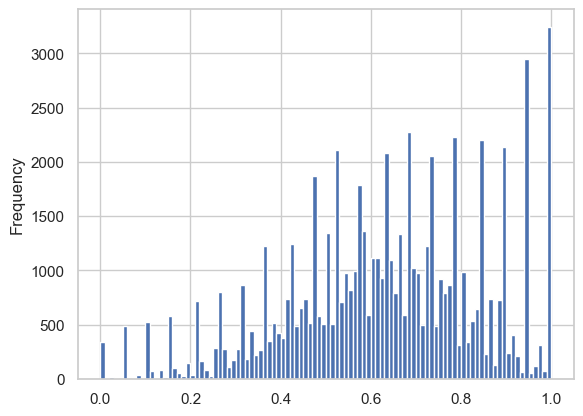

In [56]:
metrics_final = calc_user_auc(
    df=test_df_final_prediction,
    predict_col="prediction", 
    target_col="target"
)

metrics_final["rocauc"].to_pandas().plot.hist(bins=100)

In [57]:
for predict_col in als_columns + ["prediction", ]:
    metric_value = calc_user_auc(
        df=test_df_final_prediction,
        predict_col=predict_col, 
        target_col="target"
    )["rocauc"].mean()

    print(f"{predict_col}: {metric_value:.5f}")

predict_als_item_like: 0.57888
predict_als_source_like: 0.54419
predict_als_item_like_book_share: 0.57519
predict_als_source_like_book_share: 0.54144
prediction: 0.63131


In [52]:
for predict_col in als_columns + ["prediction", ]:
    metric_value = calc_user_auc(
        df=test_df_final_prediction,
        predict_col=predict_col, 
        target_col="target"
    )["rocauc"].mean()

    print(f"{predict_col}: {metric_value:.5f}")

predict_als_item_like: 0.57888
predict_als_source_like: 0.54419
predict_als_item_like_book_share: 0.57519
predict_als_source_like_book_share: 0.54144
prediction: 0.63112


In [23]:
for predict_col in als_columns + ["prediction", ]:
    metric_value = calc_user_auc(
        df=test_df_final_prediction,
        predict_col=predict_col, 
        target_col="target"
    )["rocauc"].mean()

    print(f"{predict_col}: {metric_value:.5f}")

predict_als_item_like: 0.57888
predict_als_source_like: 0.54419
predict_als_item_like_book_share: 0.57519
predict_als_source_like_book_share: 0.54144
prediction: 0.63060


In [15]:
for predict_col in als_columns + ["prediction", ]:
    metric_value = calc_user_auc(
        df=test_df_final_prediction,
        predict_col=predict_col, 
        target_col="target"
    )["rocauc"].mean()

    print(f"{predict_col}: {metric_value:.5f}")

predict_als_item_like: 0.57888
predict_als_source_like: 0.54419
predict_als_item_like_book_share: 0.57519
predict_als_source_like_book_share: 0.54144
prediction: 0.62933


In [49]:
for predict_col in als_columns + ["prediction", ]:
    metric_value = calc_user_auc(
        df=test_df_final_prediction,
        predict_col=predict_col, 
        target_col="target"
    )["rocauc"].mean()

    print(f"{predict_col}: {metric_value:.5f}")

predict_als_item_like: 0.56973
predict_als_source_like: 0.54275
predict_als_item_like_book_share: 0.56711
predict_als_source_like_book_share: 0.53934
prediction: 0.62694


### Optimize catboost

In [18]:
import optuna


def objective_cb(trial):
    iterations = trial.suggest_int('iterations', 100, 1000)
    depth = trial.suggest_int('depth', 4, 6)
    loss_function = trial.suggest_categorical('loss_function', [
        "PairLogit", "PairLogitPairwise", 
        "YetiRank", "YetiRankPairwise", 
        # "QueryRMSE", "QuerySoftMax"
    ])

    cb_model = CatBoostRanker(
        iterations=iterations, 
        depth=depth, 
        random_seed=32, 
        verbose=0, 
        loss_function=loss_function
    ).fit(
        train_df_cb_final[feature_columns], 
        train_df_cb_final["target"], 
        group_id=train_df_cb_final["user_id"]
    )

    test_df_final_prediction = (
        pl.from_pandas(test_df_final[["user_id", "target", "item_id", *als_columns]])
        .with_columns(
            pl.Series(cb_model.predict(test_df_final[feature_columns])).alias("prediction")
        )
    )

    metrics_final = calc_user_auc(
        df=test_df_final_prediction,
        predict_col="prediction", 
        target_col="target"
    )

    return calc_user_auc(
        df=test_df_final_prediction,
        predict_col=predict_col, 
        target_col="target"
    )["rocauc"].mean()


study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(objective_cb, n_trials=50)
study_cb.best_params

[I 2024-11-09 15:44:50,749] A new study created in memory with name: no-name-60baede1-9505-4de9-ac87-b7afd5468cd5
[I 2024-11-09 15:49:36,483] Trial 0 finished with value: 0.6295393932390786 and parameters: {'iterations': 655, 'depth': 4, 'loss_function': 'YetiRank'}. Best is trial 0 with value: 0.6295393932390786.
[I 2024-11-09 15:52:59,455] Trial 1 finished with value: 0.6286372090922606 and parameters: {'iterations': 463, 'depth': 4, 'loss_function': 'YetiRank'}. Best is trial 0 with value: 0.6295393932390786.
[I 2024-11-09 15:54:53,213] Trial 2 finished with value: 0.6168860195656528 and parameters: {'iterations': 178, 'depth': 4, 'loss_function': 'YetiRankPairwise'}. Best is trial 0 with value: 0.6295393932390786.
[I 2024-11-09 15:55:12,654] Trial 3 finished with value: 0.624187686906993 and parameters: {'iterations': 119, 'depth': 5, 'loss_function': 'PairLogit'}. Best is trial 0 with value: 0.6295393932390786.
[I 2024-11-09 15:58:57,695] Trial 4 finished with value: 0.62848567885

KeyboardInterrupt: 

# Финальное предсказание

In [58]:
from datetime import datetime


submission_predict = cb_model.predict(test_pairs_final[feature_columns])
test_pairs_final["predict"] = submission_predict
test_pairs_final[["user_id", "item_id", "predict"]].to_csv(f'../data/submissions/{int(datetime.now().timestamp())}_submission.csv', index=False)